In [9]:
     import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR
from datasets import inputs
import configs

device = 'cpu'

In [10]:
trained_dir = '/home/chingf/engram/Ching/'

## Plot loss for different gammas and recurrent steps

In [17]:
# Load the file
with open(f"{trained_dir}02_gamma_v_rsteps/results.p", 'rb') as f:
    results = pickle.load(f)
for key in results.keys():
    results[key] = np.array(results[key])

In [80]:
# Or gather from tfevents manually
gridsearch_dir = f"{trained_dir}02_gamma_v_rsteps/"
gamma_axes = []
rstep_axes = []
vals = []
nonlinearities = []
best_iters = []

for gamma in os.listdir(gridsearch_dir):
    gamma_dir = gridsearch_dir + f'{gamma}/'
    if not os.path.isdir(gamma_dir): continue
    for rstep in os.listdir(gamma_dir):
        rstep_dir = gamma_dir + f'{rstep}/'
        for nonlinearity in os.listdir(rstep_dir):
            nonlinearity_dir = rstep_dir + f'{nonlinearity}/'
            iter_vals = []
            for _iter in os.listdir(nonlinearity_dir):
                iter_dir = nonlinearity_dir + f'{_iter}/'
                for file in os.listdir(iter_dir):
                    if 'tfevents' not in file: continue
                    tfevents_file = iter_dir + file
                    event_acc = EventAccumulator(tfevents_file)
                    event_acc.Reload()
                    try:
                        iter_vals.append(
                            event_acc.Scalars('return_error_M')[-1].value
                            #event_acc.Scalars('loss_train')[-1].value
                            )
                    except:
                        iter_vals.append(np.nan)
            if len(iter_vals) == 0: continue
            val = np.nanmin(iter_vals)
            gamma_axes.append(gamma)
            rstep_axes.append(int(rstep))
            vals.append(val)
            nonlinearities.append(nonlinearity)
            try:
                best_iters.append(np.nanargmin(iter_vals))
            except:
                best_iters.append(0)
gamma_axes = np.array(gamma_axes)
rstep_axes = np.array(rstep_axes)
vals = np.array(vals)
nonlinearities = np.array(nonlinearities)
best_iters = np.array(best_iters)
                
results = {
    'gamma_axes': gamma_axes,
    'rstep_axes': rstep_axes,
    'vals': vals,
    'nonlinearities': nonlinearities,
    'best_iters': best_iters
}

/home/chingf/anaconda3/envs/aronov/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: All-NaN axis encountered


In [19]:
xs = np.array(results['rstep_axes'])
ys = np.array(results['gamma_axes'])
xs = np.sort(np.unique(xs))
ys = np.sort(np.unique(ys))

None


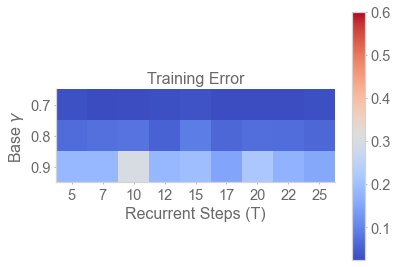

relu


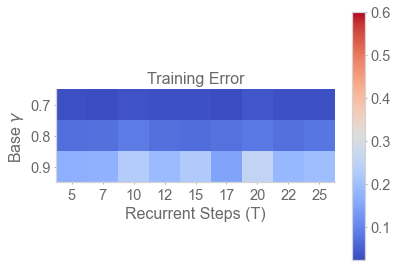

In [22]:
for nonlinearity in np.unique(nonlinearities):
    print(nonlinearity)
    mat = np.zeros((xs.size, ys.size))*np.nan
    _rsteps = results['rstep_axes'][nonlinearities == nonlinearity]
    _gammas = results['gamma_axes'][nonlinearities == nonlinearity]
    _vals = results['vals'][nonlinearities == nonlinearity]
    for rstep, gamma, val in zip(_rsteps, _gammas, _vals):
        x_idx = np.argwhere(xs == rstep)[0,0]
        y_idx = np.argwhere(ys == gamma)[0,0]
        mat[x_idx][y_idx] = val
        
    plt.figure()
    plt.imshow(mat.T, cmap="coolwarm", vmax=0.6)
    plt.yticks(np.arange(ys.size), ys)
    plt.xticks(np.arange(xs.size), xs)
    plt.xlabel('Recurrent Steps (T)')
    plt.ylabel('Base $\gamma$')
    plt.colorbar()
    plt.title("Training Error")
    plt.tight_layout()
    #plt.savefig("gamma_v_rsteps.png", dpi=300)
    plt.show()

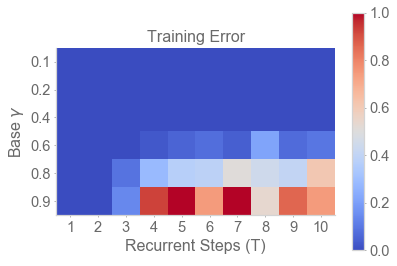

In [18]:
plt.figure()
plt.imshow(mat.T, cmap="coolwarm", vmax=1.)
plt.yticks(np.arange(ys.size), ys)
plt.xticks(np.arange(xs.size), xs)
plt.xlabel('Recurrent Steps (T)')
plt.ylabel('Base $\gamma$')
plt.colorbar()
plt.title("Training Error")
plt.tight_layout()
#plt.savefig("gamma_v_rsteps.png", dpi=300)
plt.show()

## Run test loss for different gammas and recurrent steps

In [3]:
def run(exp_dir):
    num_states = 20

    # Test dataset
    dset = inputs.Sim1DWalk(num_steps=4000, num_states=num_states, left_right_stay_prob=[4,1,1])
    dg_inputs = torch.from_numpy(dset.dg_inputs.T).float().to(device).unsqueeze(1)

    with open(exp_dir + 'net_configs.p', 'rb') as f:
        net_configs = pickle.load(f)
    net_configs['num_states'] = num_states

    # Load that model and test
    net = STDP_SR(**net_configs)
    net.load_state_dict(torch.load(exp_dir + 'model.pt'))
    net.set_num_states(num_states)
    with torch.no_grad():
        _, outputs = net(dg_inputs, reset=True)
    
    rnn_T = net.get_T().numpy()
    rnn_M = net.get_M()
    est_T = dset.est_T
    est_M = np.linalg.pinv(
        np.eye(est_T.shape[0]) - net.gamma*est_T
        )
    return np.mean(np.abs(rnn_T - est_T)), np.mean(np.abs(rnn_M - est_M))

In [5]:
# Or gather from tfevents manually
gridsearch_dir = f"{trained_dir}02_gamma_v_rsteps/"
gamma_axes = []
rstep_axes = []
mean_T_maes = []
mean_M_maes = []
min_T_maes = []
min_M_maes = []
nonlinearities = []

for gamma in os.listdir(gridsearch_dir):
    gamma_dir = gridsearch_dir + f'{gamma}/'
    if not os.path.isdir(gamma_dir): continue
    for rstep in os.listdir(gamma_dir):
        rstep_dir = gamma_dir + f'{rstep}/'
        for nonlinearity in os.listdir(rstep_dir):
            nonlinearity_dir = rstep_dir + f'{nonlinearity}/'
            iter_T_maes = []
            iter_M_maes = []
            for _iter in os.listdir(nonlinearity_dir):
                iter_dir = nonlinearity_dir + f'{_iter}/'
                if not os.path.isfile(iter_dir + 'net_configs.p'):
                    continue
                T_maes = []
                M_maes = []
                for _ in range(3):
                    T_mae, M_mae = run(iter_dir)
                    T_maes.append(T_mae)
                    M_maes.append(M_mae)
                print(M_maes)
                iter_T_maes.append(np.mean(T_maes))
                iter_M_maes.append(np.mean(M_maes))
            if len(iter_T_maes) == 0: continue
            print(nonlinearity)
            print(rstep)
            print(iter_M_maes)
            print()
            nonlinearities.append(nonlinearity)
            gamma_axes.append(gamma)
            rstep_axes.append(int(rstep))
            mean_T_maes.append(np.nanmean(iter_T_maes))
            mean_M_maes.append(np.nanmean(iter_M_maes))
            min_T_maes.append(np.nanmin(iter_T_maes))
            min_M_maes.append(np.nanmin(iter_M_maes))
gamma_axes = np.array(gamma_axes)
rstep_axes = np.array(rstep_axes)
mean_T_maes = np.array(mean_T_maes)
mean_M_maes = np.array(mean_M_maes)
min_T_maes = np.array(min_T_maes)
min_M_maes = np.array(min_M_maes)
nonlinearities = np.array(nonlinearities)
                
results = {
    'gamma_axes': gamma_axes,
    'rstep_axes': rstep_axes,
    'mean_T_maes': mean_T_maes,
    'mean_M_maes': mean_M_maes,
    'min_T_maes': min_T_maes,
    'min_M_maes': min_M_maes,
    'nonlinearities': nonlinearities
}

[0.11666664716399926, 0.11666664713265529, 0.11666664715500963]
[0.6340442459225306, 0.9537569349357932, 1.205645763495267]
[0.3451786649731872, 0.31838878579425184, 0.27179788419015116]
[0.14979384802105297, 0.26485643981616724, 0.12341616987176991]
[0.08929181162136789, 0.06541753739949895, 0.33058414649333817]
None
17
[0.11666664715055473, 0.931148981451197, 0.3117884449858634, 0.17935548590299674, 0.16176449850473498]

[0.26502140529958496, 0.3393608450711581, 0.26449118580828845]
[0.08322695438326627, 0.0866265823645102, 0.07936077326988057]
[0.5556430559626406, 0.7115983185916969, 0.6361763280940949]
[0.250393449215091, 0.2933848861575365, 0.31477614204643156]
[0.04005675888789014, 0.05210571119693808, 0.03730666970176809]
relu
17
[0.28962447872634384, 0.08307143667255235, 0.6344725675494775, 0.286184825806353, 0.04315637992886543]

[0.11666664718542279, 0.11666664714540759, 0.11666664715470194]
[364494.6334896029, 0.9436076008778868, 1563.8026026857929]
[0.3264273729874961, 0.35

[0.08214303540825575, 0.08940224959332771, 0.13963906678940385]
[0.6510246831235352, 0.5368700735053306, 0.4990247948683284]
relu
17
[0.7761198153560979, 4.688496447235136, 0.07846002878327597, 0.10372811726366243, 0.5623065171657314]

[2.5553839103396987, 2.832509158961598, 0.42252410261059326]
[0.5834440638208865, 1.578525392823771, 2.25003707947767]
[0.23440606411118334, 0.19969364772103831, 0.24173159572482214]
[1.0869342205168242, 1.7850638658403986, 1.1628263037706197]
[0.38185910612330765, 0.29149923300930103, 0.3093554472559566]
None
25
[1.93680572397063, 1.4706688453741092, 0.2252771025190146, 1.3449414633759476, 0.32757126212952176]

[0.17935524964232344, 0.17827879557940482, 0.17901927394429668]
[0.1044926563888881, 0.11706042400273803, 0.10923860753665356]
[2.5422534970986788, 1.1295649168444393, 1.284662273348767]
[0.791372059215667, 0.8768395966296677, 1.3208738854577495]
[0.08107747163483307, 0.07889660066653474, 0.07460011679725052]
relu
25
[0.17888443972200832, 0.11026

[0.2553893209622774, 0.2513301294713281, 0.3062308467626724]
[0.30410967796423644, 0.2927717037113505, 0.2940461576057762]
[0.27182869379636776, 0.2655150526916072, 0.28447291118524193]
[0.21474604071148792, 0.2547639130252082, 0.19962060555682878]
[0.35370414172114806, 0.24171568463587945, 0.2455946151811181]
relu
25
[0.27098343239875927, 0.29697584642712105, 0.2739388858910723, 0.2230435197645083, 0.2803381471793819]

[0.8194878078490457, 0.3015062217661618, 0.43551501461646763]
[0.6069259502386349, 0.7126243096389158, 1.2673986217304438]
[0.598542203831925, 11.135413373133952, 0.7905077274696578]
[0.35391182569370855, 0.7999363558131626, 1.7935718512318162]
[3.867007746046944, 1.4531636165613262, 1.517794721776592]
None
20
[0.5188363480772251, 0.8623162938693314, 4.1748211014785115, 0.9824733442462291, 2.2793220281282873]

[0.23231439721906524, 0.19713138589741244, 0.18409148162535968]
[0.35441838449694374, 0.33114140443017137, 0.3103544490229069]
[0.32540093991964253, 0.28763279733

In [6]:
xs = np.array(results['rstep_axes'])
ys = np.array(results['gamma_axes'])
xs = np.sort(np.unique(xs))
ys = np.sort(np.unique(ys))

In [23]:
for nonlinearity in np.unique(nonlinearities):
    print(nonlinearity)
    mat = np.zeros((xs.size, ys.size))*np.nan
    _rsteps = results['rstep_axes'][nonlinearities == nonlinearity]
    _gammas = results['gamma_axes'][nonlinearities == nonlinearity]
    _vals = results['min_M_maes'][nonlinearities == nonlinearity]
    for rstep, gamma, val in zip(_rsteps, _gammas, _vals):
        x_idx = np.argwhere(xs == rstep)[0,0]
        y_idx = np.argwhere(ys == gamma)[0,0]
        #if float(gamma) > 0.7: continue
        mat[x_idx][y_idx] = val
        
    plt.figure()
    plt.imshow(mat.T, cmap="Blues_r", vmax=0.5)
    plt.yticks(np.arange(ys.size), ys)
    plt.xticks(np.arange(xs.size), xs)
    plt.xlabel('Recurrent Steps (T)')
    plt.ylabel('Base $\gamma$')
    plt.colorbar()
    plt.title("Training Error")
    plt.tight_layout()
    #plt.savefig("gamma_v_rsteps.png", dpi=300)
    plt.show()

None


KeyError: 'min_M_maes'

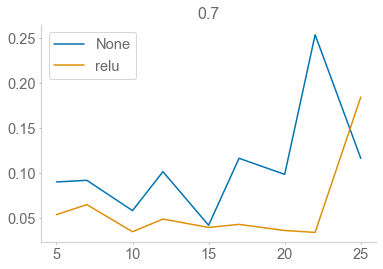

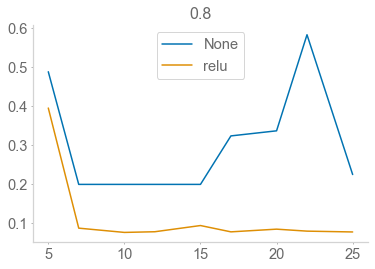

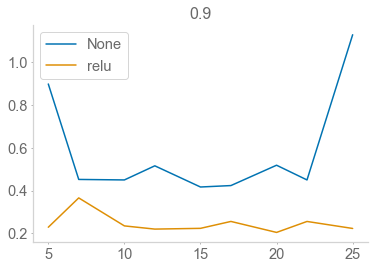

In [8]:
for gamma in ['0.7', '0.8', '0.9']:
    plt.figure()
    for nonlinearity in np.unique(nonlinearities):
        idx = np.logical_and(
            nonlinearities == nonlinearity,
            results['gamma_axes'] == gamma
            )
        _rsteps = results['rstep_axes'][idx]
        _vals = results['min_M_maes'][idx]
        sort_idxs = np.argsort(_rsteps)
        _rsteps = _rsteps[sort_idxs]
        _vals = _vals[sort_idxs]
        plt.plot(_rsteps, _vals, label=nonlinearity)
    plt.title(f'{gamma}')
    plt.legend()
    plt.show()